# LMS Exploration | 9. Movie_Recommendation_System

---

**[Introduce]**  

우리가 좋아할 만한 영화를 추천받아봅시다!

MovieLens Dataset을 implicit 데이터로 간주하고 MF모델을 구성하고,
implicit 패키지의 AlternatingLeastSquares 모델으로 학습해봅니다. 


**[Data]**  

* 추천시스템의 MNIST,  [Movielens 데이터](https://files.grouplens.org/datasets/movielens/ml-1m-README.txt)
* 유저가 영화에 대해 평점을 매긴 데이터 중 MovieLens 1M Dataset 사용합니다.


    These files contain 1,000,209 anonymous ratings of approximately 3,900 movies   
    made by 6,040 MovieLens users who joined MovieLens in 2000.  


* 별점 데이터는 대표적 explicit 데이터이지만 implicit 데이터로 간주하고 테스트 해보겠습니다.
* 별점을 시청횟수로 해석합니다.
* 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외합니다.

**[Preparation]**

심볼릭 링크로 연결
```python
$ mkdir -p ~/aiffel/recommendata_iu/data/ml-1m
$ ln -s ~/data/ml-1m/* ~/aiffel/recommendata_iu/data/ml-1m
```

# 1. 데이터 준비와 전처리
    1-0. 데이터 불러오기
    1-1. 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외
    1-2. 별점을 시청횟수로 해석
    1-3. 영화 제목이 담긴 메타 데이터 읽어오기


## 1-0. 데이터 불러오기
사용자 아이디, 영화 아이디, 평점, 타임스탬프로 구성된 rating.dat 데이터를 확인해보겠습니다.  
Movielens 데이터는 rating.dat 안에 이미 인덱싱까지 완료된 사용자-영화-평점 데이터가 깔끔히 정리되어 있습니다. ^__^  
아래는 Movielens 데이터 구성에 대한 설명글입니다 

    Ratings file Description
    All ratings are contained in the file "ratings.dat" and are in the
    following format:

    UserID::MovieID::Rating::Timestamp

    - UserIDs range between 1 and 6040 
    - MovieIDs range between 1 and 3952
    - Ratings are made on a 5-star scale (whole-star ratings only)
    - Timestamp is represented in seconds since the epoch as returned by time(2)
    - Each user has at least 20 ratings

In [1]:
import os 
import pandas as pd

In [2]:
rating_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding="ISO-8859-1")
original_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


[pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)
```
engine : {‘c’, ‘python’}, optional
Parser engine to use. The C engine is faster while the python engine is currently more feature-complete.

encoding : str, optional
Encoding to use for UTF when reading/writing (ex. ‘utf-8’). 

-UTF-8은 모든 유니 코드 문자를 나타낼 수있는 멀티 바이트 인코딩인 반면, ISO 8859-1은 첫 256 개의 유니 코드 문자를 나타낼 수있는 1 바이트 인코딩이다. 둘 다 ASCII를 정확히 같은 방식으로 인코딩한다.

ISO-8859-1 : 8 비트. 256 개의 코드 포인트.
UTF-8 : 8-32 비트 (1-4 바이트). 코드 포인트 1,112,064 개

```

## 1-1. 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외

In [3]:
#- 3점 이상만 남기기

ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'original_data_size: {original_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / original_data_size:.2%}')

original_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


## 1-2. 별점을 시청횟수로 해석

In [4]:
#- rating 컬럼의 이름을 count로 바꾸기

ratings.rename(columns={'rating':'count'}, inplace=True)

## 1-3. 영화 제목이 담긴 메타 데이터 읽어오기
메타데이터란 데이터에 관한 구조화된 데이터로, 다른 데이터를 설명해 주는 데이터입니다.  
영화 아이디에 대응하는 영화제목과 장르로 구성된 Movies.dat 파일을 확인해보겠습니다.   
아래는 Movies 데이터 구성에 대한 설명글입니다.   

    MOVIES FILE DESCRIPTION
    Movie information is in the file "movies.dat" and is in the following
    format:

    MovieID::Title::Genres

    - Titles are identical to titles provided by the IMDB (including
    year of release)
    - Genres are pipe-separated and are selected from the following genres:

        * Action
        * Adventure
        * Animation
        * Children's
        * Comedy
        * Crime
        * Documentary
        * Drama
        * Fantasy
        * Film-Noir
        * Horror
        * Musical
        * Mystery
        * Romance
        * Sci-Fi
        * Thriller
        * War
        * Western

    - Some MovieIDs do not correspond to a movie due to accidental duplicate
    entries and/or test entries
    - Movies are mostly entered by hand, so errors and inconsistencies may exist


In [5]:
movie_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre']
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [40]:
movies.shape #- movies 데이터의 영화는 3883 개가 입니다. 

(3883, 3)

In [6]:
movies['genre'].unique()[:10]

array(["Animation|Children's|Comedy", "Adventure|Children's|Fantasy",
       'Comedy|Romance', 'Comedy|Drama', 'Comedy',
       'Action|Crime|Thriller', "Adventure|Children's", 'Action',
       'Action|Adventure|Thriller', 'Comedy|Drama|Romance'], dtype=object)

각 영화가 단순히 하나의 장르로 표현되는 것이 아니라 다양한 장르의 조합으로 표현됨을 알 수 있습니다.


# 2. MF(Matrix Factorization) 모델 구성

- MF의 목적은 Matrix Complement 로, 아직 평가를 내리지 않은 user-item의 빈 공간을 Model-based Learning으로 채워넣는 것입니다.
- 유저간, 혹은 아이템간 유사도를 이용하는 Memory-based 방법과 달리, MF는 행렬 인수 분해라는 수학적 방법으로 접근합니다. 
- 행렬은 두개의 하위 행렬로 분해가 가능하며, 다시 곱해져서 원래 행렬과 동일한 크기의 단일 행렬이 될 수 있다는 성질을 이용하는 것입니다.
- 행렬 인수 분해의 원칙은 비평가 항목을 채우기 위함입니다.
 
 
    1-0. 사전만들기
    1-1. 내가 선호하는 영화 6가지를 골라 rating에 추가하기
    1-2. CSR matrix 만들기
    

참고 : [efficient way to create a dictionary of two pandas Dataframe columns](https://stackoverflow.com/questions/17426292/what-is-the-most-efficient-way-to-create-a-dictionary-of-two-pandas-dataframe-co)

## 1-0. 사전만들기

이후 데이터프레임으로 보기좋게 출력하기 위해서 미리 사전을 만들었습니다.

    movie_id : genre  
    movie_name : movie_id  
    movie_id : movie_name  


In [7]:
movie_id_to_genre = pd.Series(movies.genre.values, index=movies.movie_id).to_dict()
movie_id_to_genre_show = pd.Series(movie_id_to_genre)
movie_id_to_genre_show.head(5)

1     Animation|Children's|Comedy
2    Adventure|Children's|Fantasy
3                  Comedy|Romance
4                    Comedy|Drama
5                          Comedy
dtype: object

In [8]:
movie_to_idx = pd.Series(movies.movie_id.values,index=movies.title).to_dict()

movie_id_idx_show = pd.Series(movie_to_idx)
movie_id_idx_show.head(5)

Toy Story (1995)                      1
Jumanji (1995)                        2
Grumpier Old Men (1995)               3
Waiting to Exhale (1995)              4
Father of the Bride Part II (1995)    5
dtype: int64

In [9]:
idx_to_movie = {v:k for k,v in movie_to_idx.items()}

idx_to_movie_show = pd.Series(idx_to_movie)
idx_to_movie_show.head(5)

1                      Toy Story (1995)
2                        Jumanji (1995)
3               Grumpier Old Men (1995)
4              Waiting to Exhale (1995)
5    Father of the Bride Part II (1995)
dtype: object

## 1-1. 내가 선호하는 영화 6가지를 골라 rating에 추가하기

이후 학습된 모델에게 영화를 추천받기 위해서 '내가 좋아하는 영화' 정보를 추가해줍니다.  
저는 아이디 '61616' 으로 해서 6가지 영화를 추가했습니다.   
저는 어떤 영화를 추가했을까요??



제가 좋아하는 영화를 추가하기 앞서서 데이터에 어떤 영화가 있는지, 사용자는 몇 명이나 있는지 확인해보겠습니다.  

* ratings에 있는 유니크한 영화 개수 : 3628
* ratingS에 있는 유니크한 사용자 수 : 6039
* 가장 인기 있는 영화 30개(인기순)

In [10]:
#- ratings 데이터에서 유니크한 영화 개수 & 유니크한 사용자 수
num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()
print(f'number of unique users: {num_user}, number of unique movies: {num_movie}')

number of unique users: 6039, number of unique movies: 3628


In [11]:
#- 가장 인기 있는 영화 30선 

temp_movie_data = ratings['movie_id'].map(idx_to_movie.get)

movie_name_ratings = ratings.copy() #- movie_id 를 영화 이름으로 변환할 df 생성
movie_name_ratings['movie_id'] = temp_movie_data
movie_count = movie_name_ratings.groupby('movie_id')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

movie_id
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257

### 내가 좋아하는 영화 추가하기

예전에는 리틀포레스트 같은 잔잔한 drama 장르나 animation 을 좋아했는데,  
지금은 좋아하는 장르가 확장됐습니다. SF, 액션도 재밌더라구요.  

저는 공포만 아니면 좋아요 ^__^  

In [12]:
my_favorite_movie = [ 'Terminator 2: Judgment Day (1991)', 'Matrix, The (1999)', 'Toy Story (1995)', 'Men in Black (1997)', 'Good Will Hunting (1997)','Silence of the Lambs, The (1991)']
my_favorite = list(map(movie_to_idx.get, my_favorite_movie))
my_favorite

[589, 2571, 1, 1580, 1704, 593]

In [13]:
#- 제가 좋아하는 영화입니다.

my_favorite_genre = map(movie_id_to_genre.get, my_favorite)
my_favorite_movie_show = pd.DataFrame(data = list(zip(my_favorite, my_favorite_movie, my_favorite_genre )),columns = ['영화 ID','영화 이름', '영화 장르'])
my_favorite_movie_show.set_index('영화 ID', inplace = True)
my_favorite_movie_show

,영화 이름,영화 장르
영화 ID,,
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
1,Toy Story (1995),Animation|Children's|Comedy
1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
1704,Good Will Hunting (1997),Drama
593,"Silence of the Lambs, The (1991)",Drama|Thriller


유저 아이디를 '61616'로 설정했습니다.  
ratings dataset 마지막에 잘 추가됐네요~  

In [14]:
my_movielist = pd.DataFrame({'user_id' : ['61616']*6, 'movie_id': my_favorite, 'count':[5]*6, 'timestamp':[0]*6 })

In [15]:
if not ratings.isin({'user_id':['61616']})['user_id'].any(): 
    ratings = ratings.append(my_movielist)
ratings.tail(10)

,user_id,movie_id,count,timestamp
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648
1000208,6040,1097,4,956715569
0,61616,589,5,0
1,61616,2571,5,0
2,61616,1,5,0
3,61616,1580,5,0
4,61616,1704,5,0
5,61616,593,5,0


아래는 각 유저가 몇 개의 (Movies.dat에 있는) 영화를 봤는지 scatterplot으로 나타낸 것입니다.    
전체 영화종류가 약 3900개 일때, 약6000명의 각 유저는 1000개 이하의 영화를 봤습니다.   
유저 수 X 영화 수 로 구성된 평가행렬을 만들 경우 수많은 0 값이 생길 것을 예상할 수 있습니다.  

<class 'pandas.core.series.Series'>


Text(59000, 500, 'my ID')

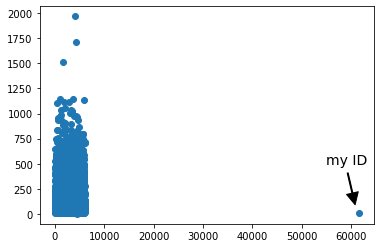

In [16]:
import matplotlib.pyplot as plt
freq = ratings['user_id'].value_counts()
print(type(freq))
plt.scatter(freq.index, freq.values)
plt.annotate('my ID', xy=(61000, 50), xytext=(59000,500),
            fontsize=14, ha='center',
            arrowprops=dict(facecolor='black', width=1, shrink=0.1))

## 1-2. CSR matrix 만들기
평가행렬에는 유저 수 X 영화 수 만큼의 정보가 포함되어, 유저가 본 적이 없는 영화에 대한 정보까지도 모두 행렬에 포함되어 계산되게 됩니다. 약 3900 개의 영화 중에서 유저가 본 적이 없는 영화는 절반 이상일 것이고, 수많은 값이 0 으로 채워질 것입니다. 이러한 행렬을 Sparse Matrix라고 합니다. 

이때 발생하는 메모리 낭비를 최소화하기 위해서는 유저가 시청한 영화에 대해서만 정보만을 저장하면서 전체 행렬 형태를 유추할 수 있는 데이터 구조가 필요합니다.

**CSR Matrix**는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조입니다.  


In [17]:
ratings.dtypes

user_id      object
movie_id      int64
count         int64
timestamp     int64
dtype: object

user_id 를 추가해주었기 때문에 user_id의 dtype이 object로 나타납니다. ratings의 dtype을 int64로 변환해줍니다.

In [18]:
ratings=ratings.astype('int64')
ratings.dtypes

user_id      int64
movie_id     int64
count        int64
timestamp    int64
dtype: object

In [19]:
print(ratings.shape)
print(num_user, num_movie)

(836484, 4)
6039 3628


In [20]:
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()

csr_data = csr_matrix((ratings['count'], (ratings.user_id, ratings.movie_id)))
csr_data

<61617x3953 sparse matrix of type '<class 'numpy.longlong'>'
	with 836484 stored elements in Compressed Sparse Row format>

# 3. 학습 | Alternating Least Squares 
- implicit 패키지는 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지입니다.
- 이 패키지에 구현된 als(AlternatingLeastSquares) 모델을 사용해보겠습니다.
- **Matrix Factorization**에서 쪼개진 두 Feature Matrix를 한꺼번에 훈련하는 것은 잘 수렴하지 않기 때문에, 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적인 것으로 알려져 있습니다.

---

[AlternatingLeastSquares ](https://implicit.readthedocs.io/en/stable/als.html)
```
A Recommendation Model based of the algorithms described in the paper ‘Collaborative Filtering for Implicit Feedback Datasets’ with performance optimizations described in ‘Applications of the Conjugate Gradient Method for Implicit Feedback Collaborative Filtering.’  


AlternatingLeastSquares 클래스의 __init__ 파라미터

1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지 
2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지 
3. use_gpu : GPU를 사용할 것인지
4. iterations : epochs와 같은 의미


위 1,4를 늘릴수록 학습데이터를 잘 학습하게 되지만 과적합의 우려가 있습니다. 
```

In [21]:
from implicit.als import AlternatingLeastSquares
import numpy as np

#- implicit 라이브러리에서 권장하는 부분
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [22]:
#- Implicit AlternatingLeatSquares 모델의 선언

als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [23]:
#- als 모델은 input으로 item X user 꼴의 matrix를 받기 때문에 Transpose 해줘야 합니다.

csr_data_transpose = csr_data.T
csr_data_transpose

<3953x61617 sparse matrix of type '<class 'numpy.longlong'>'
	with 836484 stored elements in Compressed Sparse Column format>

In [24]:
#- 모델 훈련

als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

# 4. 모델학습 후 추론

훈련된 모델이 예측한 나의 선호도 알아봅시다. 
내가 선호하는 6가지 영화와 그 외의 영화의 선호도를 비교해보겠습니다.

4-1. 유사한 영화 추출하기

In [25]:
my_favorite_ratings = {}
for movie_id in my_favorite:
    name_vector, movie_vector = als_model.user_factors[616], als_model.item_factors[movie_id]
    my_favorite_ratings[idx_to_movie[movie_id]] = np.dot(name_vector, movie_vector)

my_favorite_movie_show['선호도']=my_favorite_ratings.values()
my_favorite_movie_show.sort_values(by=["선호도"], ascending=False, inplace=True) 
my_favorite_movie_show

,영화 이름,영화 장르,선호도
영화 ID,,,
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.970676
1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.808194
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.407001
593,"Silence of the Lambs, The (1991)",Drama|Thriller,0.077962
1,Toy Story (1995),Animation|Children's|Comedy,-0.009396
1704,Good Will Hunting (1997),Drama,-0.139395


In [26]:
popular_movie_count = movie_count.sort_values(ascending=False)[:20]
popular_movie_count
my_ratings = {}
for movie in popular_movie_count.index:
    if movie in my_favorite_movie:
        continue
    
    name_vector, movie_vector = als_model.user_factors[616], als_model.item_factors[movie_to_idx[movie]]
    my_ratings[movie] = np.dot(name_vector, movie_vector)

popular_movie_name =list(my_ratings.keys())
popular_movie_id = list(map(movie_to_idx.get, popular_movie_name))
popular_movie_genre = list(map(movie_id_to_genre.get, popular_movie_id))
popular_movie_rating = list(my_ratings.values())

my_ratings = pd.DataFrame(data = zip(popular_movie_id,popular_movie_name,popular_movie_genre,popular_movie_rating), columns=['영화 ID','영화 이름','영화 장르','선호도'])
my_ratings.set_index('영화 ID', inplace = True)
my_ratings.sort_values(by=["선호도"], ascending=False, inplace=True) 
my_ratings

,영화 이름,영화 장르,선호도
영화 ID,,,
110,Braveheart (1995),Action|Drama|War,0.995268
480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.976785
2858,American Beauty (1999),Comedy|Drama,0.970412
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,0.894078
1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,0.846114
1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,0.707275
1198,Raiders of the Lost Ark (1981),Action|Adventure,0.619077
1270,Back to the Future (1985),Comedy|Sci-Fi,0.406946
1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller,0.250041


## 4-1. 유사한 영화 추출하기
제가 좋아하는 영화로 추가했던 Matrix, The (1999) 와 유사한 영화를 추출해보겠습니다.


학습에 사용한 CSR data는 유저아이디, 영화아이디, 시청한 횟수(implicit으로 간주)정보만 들어있었는데,  
비슷한 장르의 영화들을 잘 추출해내는 것을 보니 학습이 잘 된 것 같습니다   

In [41]:
similar_movie = als_model.similar_items(2571, N=10) #- 2571 Matrix, The (1999)
similar_movie

[(2571, 1.0000001),
 (589, 0.7510936),
 (2916, 0.6367025),
 (457, 0.5822002),
 (1240, 0.55028695),
 (480, 0.5137215),
 (1527, 0.513271),
 (1573, 0.5016243),
 (1580, 0.48548228),
 (32, 0.4547885)]

아래 결과를 살펴보면, Matrix와 같은 장르인 Action|Sci-Fi|Thriller 에 속하는 영화들이 추출되었음을 알 수 있습니다.  

In [42]:
similar_movie_name = [idx_to_movie[i[0]] for i in similar_movie]
similar_movie_id = [i[0] for i in similar_movie]
similar_movie_genre = [movie_id_to_genre[i[0]] for i in similar_movie]
similarity = [i[1] for i in similar_movie]
similar_movie_df = pd.DataFrame(data=zip(similar_movie_id,similar_movie_name,similar_movie_genre,similarity), columns = ['movie_id','similar_movie','genre','similarity'])
similar_movie_df.set_index('movie_id', inplace = True)
similar_movie_df

,similar_movie,genre,similarity
movie_id,,,
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1.000000
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.751094
2916,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller,0.636702
457,"Fugitive, The (1993)",Action|Thriller,0.582200
1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,0.550287
480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.513722
1527,"Fifth Element, The (1997)",Action|Sci-Fi,0.513271
1573,Face/Off (1997),Action|Sci-Fi|Thriller,0.501624
1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.485482


In [43]:
def get_similar_movie(movie_name: str, N=10):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id, N)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie]
    return similar_movie

In [44]:
def get_similar_movie_df(movie_name: str, N=10):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id, N)
    similar_movie_name = [idx_to_movie[i[0]] for i in similar_movie]
    similar_movie_id = [i[0] for i in similar_movie]
    similar_movie_genre = [movie_id_to_genre[i[0]] for i in similar_movie]
    similarity = [i[1] for i in similar_movie]
    similar_movie_df = pd.DataFrame(data=zip(similar_movie_id,similar_movie_name,similar_movie_genre,similarity), columns = ['movie_id','similar_movie','genre','similarity'])
    similar_movie_df.set_index('movie_id', inplace = True)
    return similar_movie_df

In [45]:
get_similar_movie_df('Toy Story 2 (1999)')

,similar_movie,genre,similarity
movie_id,,,
3114,Toy Story 2 (1999),Animation|Children's|Comedy,1.000000
1,Toy Story (1995),Animation|Children's|Comedy,0.809293
2355,"Bug's Life, A (1998)",Animation|Children's|Comedy,0.643636
3157,Stuart Little (1999),Children's|Comedy,0.405639
588,Aladdin (1992),Animation|Children's|Comedy|Musical,0.403483
34,Babe (1995),Children's|Comedy|Drama,0.401081
2761,"Iron Giant, The (1999)",Animation|Children's,0.397564
2396,Shakespeare in Love (1998),Comedy|Romance,0.350097
2687,Tarzan (1999),Animation|Children's,0.336711


In [32]:
get_similar_movie_df('Silence of the Lambs, The (1991)')

,similar_movie,genre,similarity
movie_id,,,
593,"Silence of the Lambs, The (1991)",Drama|Thriller,1.000000
318,"Shawshank Redemption, The (1994)",Drama,0.762379
608,Fargo (1996),Crime|Drama|Thriller,0.748150
296,Pulp Fiction (1994),Crime|Drama,0.647199
50,"Usual Suspects, The (1995)",Crime|Thriller,0.528101
527,Schindler's List (1993),Drama|War,0.525350
1213,GoodFellas (1990),Crime|Drama,0.512818
1704,Good Will Hunting (1997),Drama,0.489894
2762,"Sixth Sense, The (1999)",Thriller,0.464684


## 4-2.내가 좋아할만한 영화 추천받기
드디어 !!    
✧*.◟(ˊᗨˋ)◞.*✧  
  
제가 좋아할만한 영화를 20개 추천받아보겠습니다.

In [33]:
movie_recommended = als_model.recommend(61616, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(480, 0.5526022),
 (318, 0.47674063),
 (2916, 0.46952188),
 (608, 0.43124473),
 (457, 0.42992675),
 (3114, 0.38861728),
 (2762, 0.38201505),
 (2028, 0.36644766),
 (527, 0.35968703),
 (110, 0.34861717),
 (296, 0.3374632),
 (1240, 0.31850922),
 (32, 0.29674768),
 (34, 0.29004714),
 (50, 0.28929237),
 (356, 0.27508992),
 (1617, 0.27435392),
 (2355, 0.26943994),
 (1265, 0.26384237),
 (1270, 0.26253468)]

In [34]:
def get_recommended_movie_df(user_id, N=20):
    '''parameter N is number of recommendation'''
    movie_recommended = als_model.recommend(user_id, csr_data, N=N, filter_already_liked_items=True)
    recommended_movie_name = [idx_to_movie[i[0]] for i in movie_recommended]
    recommended_movie_id = [i[0] for i in movie_recommended]
    recommended_movie_genre = [movie_id_to_genre[i[0]] for i in movie_recommended]
    recommendation = [i[1] for i in movie_recommended]
    recommended_movie_df = pd.DataFrame(data=zip(recommended_movie_id,recommended_movie_name,recommended_movie_genre,recommendation), columns = ['movie_id','recommended_movie','genre','recommendation'])
    recommended_movie_df.set_index('movie_id', inplace = True)
    return recommended_movie_df

결과를 보니 다행히 호러 영화는 없군요 (^▽^)/ ʸᵉᔆᵎ
  
추천해주신 영화를 한번 보고 모델 평가하도록 하겠습니다. ㅎㅎㅎ

In [35]:
my_recommendation = get_recommended_movie_df(61616, 20)
my_recommendation

,recommended_movie,genre,recommendation
movie_id,,,
480,Jurassic Park (1993),Action|Adventure|Sci-Fi,0.552602
318,"Shawshank Redemption, The (1994)",Drama,0.476741
2916,Total Recall (1990),Action|Adventure|Sci-Fi|Thriller,0.469522
608,Fargo (1996),Crime|Drama|Thriller,0.431245
457,"Fugitive, The (1993)",Action|Thriller,0.429927
3114,Toy Story 2 (1999),Animation|Children's|Comedy,0.388617
2762,"Sixth Sense, The (1999)",Thriller,0.382015
2028,Saving Private Ryan (1998),Action|Drama|War,0.366448
527,Schindler's List (1993),Drama|War,0.359687


## 4-3. 추천 기여도 살펴보기


    추천시스템이 어떤 근거로 저런 영화들을 추천해줬는지 궁금하네요 ~    
    제가 좋아해서 5번씩 봤던 영화들의 기여도를 한번 살펴보겠습니다.        

In [59]:
def explain_recommendation_df(user_id, recommended_movie_id):
    explain = als_model.explain(user_id, csr_data, itemid=recommended_movie_id)
    explain_movie_name = [idx_to_movie[i[0]] for i in explain[1]]
    explain_movie_id = [movie_to_idx[i] for i in explain_movie_name]
    explain_movie_genre = [movie_id_to_genre[i] for i in explain_movie_id]
    explainatory = [i[1] for i in explain[1]]
    explain_recommendation_df = pd.DataFrame(data=zip(explain_movie_id,explain_movie_name,explain_movie_genre,explainatory), columns = ['movie_id','movie','genre','explanatory'])
    explain_recommendation_df.set_index('movie_id', inplace = True)
    print('ಇ( ˵ᐛ ˵)ಇ')
    print(f'은서 : 저에게 [{idx_to_movie[recommended_movie_id]}]가 추천된 이유를 설명해주세요~')
    print(f'AI : 휴먼~ 간단하다구')
    return explain_recommendation_df

In [60]:
explain_my_recommendation = explain_recommendation_df(61616, 480)
explain_my_recommendation 

ಇ( ˵ᐛ ˵)ಇ
은서 : 저에게 [Jurassic Park (1993)]가 추천된 이유를 설명해주세요~
AI : 휴먼~ 간단하다구


,movie,genre,explanatory
movie_id,,,
1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,0.298393
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.195392
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,0.101992
593,"Silence of the Lambs, The (1991)",Drama|Thriller,-0.003495
1704,Good Will Hunting (1997),Drama,-0.008159
1,Toy Story (1995),Animation|Children's|Comedy,-0.039845


In [61]:
explain_my_recommendation = explain_recommendation_df(61616, 318)
explain_my_recommendation 

ಇ( ˵ᐛ ˵)ಇ
은서 : 저에게 [Shawshank Redemption, The (1994)]가 추천된 이유를 설명해주세요~
AI : 휴먼~ 간단하다구


,movie,genre,explanatory
movie_id,,,
593,"Silence of the Lambs, The (1991)",Drama|Thriller,0.260335
1704,Good Will Hunting (1997),Drama,0.195182
1,Toy Story (1995),Animation|Children's|Comedy,0.033358
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,0.004805
1580,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi,-0.010894
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,-0.011750


# 5. 추천시스템 평가하기 | Mean Average Precision(MAP)
Mean Average Precision(MAP)은 
* 정보를 순서를 지정하여(Ranked) 반환하는 경우에 사용하는 평가방법입니다.
* 예를들어 구글과 같은 검색엔진에서 검색결과가 검색의도와 관련도가 높은 순으로 잘 나열되어있는지를 평가하는 방법입니다.

* 추천시스템은 수많은 아이템 중에 사용자가 관심을 보일만한 아이템들을 보여준며 가장 자신있는 것을 첫 번째로 보여준다는 점에서 검색엔진과 의미가 동일하며 따라서 MAP은 추천시스템의 평가방법으로도 유용합니다.

평가 지표중 하나인 precision 및 recall 값은 순서를 고려하지 않지만, MAP은 순서를 고려하기 위해 K값을 설정합니다. 

    Precision : 우리가 추천한 아이템 중에 사용자가 정말 관심있어하는 아이템의 비율  
    Recall : 실제로 사용자가 관심있어하는 아이템 중에 우리가 추천한 아이템의 비율  


---

실제로 구현해보고 싶었으나, 시간적 여유가 없었다. 이후에 다시 해봐야겠다.  

# 6. 자기평가 
CSR matrix를 통해, 평가행렬을 두개의 행렬의 곱으로 표현할 수 있다는 간단한 아이디어로 메모리 문제를 해결하고 0값을 새로운 값으로 채워넣어 성능을 향상시켰다는 점이 흥미로웠다.   
쉬워보이지만 촌철살인과 같은 아이디어를 내기 위해서는 탄탄한 이론적 기반과 남다른 창의성이 필요할 것이라 생각한다.    
멋지다.    

복잡해보이는 문제의 실마리를 잘 찾으면 후루룩 풀어지는 문제가 있는 것이다.   
내이름의 서(緖)자가 실마리 서(緖)인데, 실마리를 잘 찾아가는 삶을 살아야겠다.   

♪(*´θ｀)ノ